In [ ]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh


# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
# plt.rcParams['figure.figsize'] = (16,9)

import mpld3

In [ ]:
# reload(sdh)

In [ ]:
# reload(nn)
import relembed_single as nn

In [ ]:
# reload(eh)
import experiment_helper as eh

In [ ]:
shuffle_seed = 20

In [ ]:
reload(dh)
DH = dh.DataHandler('data/semeval_wiki_sdp_include_single_50000', valid_percent=1, shuffle_seed=shuffle_seed) # for semeval

In [ ]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=False, shuffle_seed=shuffle_seed, single=False)
num_classes = len(int2label.keys())

In [ ]:
# get a sense of the data
for i, (sdp, (x, y), label) in enumerate(zip(train['sdps'], train['targets'], train['labels'])[:100]):
    print("%i : %r : <%s> %r <%s>" 
          % (i, int2label[label], x, " ".join([s[0] for s in sdp]), y))

In [ ]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

print(train['targets'][:5]) # small sample

In [ ]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

In [ ]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM
# normalize them
word_embeddings /= np.sqrt(np.sum(word_embeddings**2, 1, keepdims=True))

In [ ]:
# REL EMBED AVERAGE MODEL
"""
Relation Embed model
"""
class RelEmbed(object):
    def __init__(self, config):
        self.config = config
        self.max_num_steps = config['max_num_steps']
        self.word_embed_size = config['word_embed_size']
        self.dep_embed_size = config['dep_embed_size']
        self.pos_embed_size = config['pos_embed_size']
        self.hidden_layer_size = config['hidden_layer_size']
        self.input_size = self.word_embed_size + self.dep_embed_size + self.pos_embed_size
        self.bidirectional = config['bidirectional']
        self.hidden_size = self.word_embed_size #config['hidden_size']
        self.pretrained_word_embeddings = config['pretrained_word_embeddings'] # None if we don't provide them
        if np.any(self.pretrained_word_embeddings):
            assert self.word_embed_size == self.pretrained_word_embeddings.shape[1]
        self.num_classes = config['num_predict_classes']
        self.max_grad_norm = config['max_grad_norm']

        self.predict_style = 'END' # could be 'ALL' or 'AVG' also
        
        self.vocab_size = config['vocab_size']
        self.dep_vocab_size = config['dep_vocab_size']
        self.pos_vocab_size = config['pos_vocab_size']
        self.name = config['model_name']
        self.checkpoint_prefix = config['checkpoint_prefix'] + self.name
        self.summary_prefix = config['summary_prefix'] + self.name
        
        self.initializer = tf.random_uniform_initializer(-1., 1.)
        self.word_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=1./(self.word_embed_size))
        self.dep_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=1./(self.dep_embed_size))
        self.pos_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=1./(self.pos_embed_size))
        self.hidden_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=1./(self.hidden_size))
        with tf.name_scope(self.name):
            with tf.name_scope("Forward"):
                self._build_forward_graph()
            with tf.name_scope("Classifier"):
                if config['supervised']:
                    self._build_classification_graph()
            with tf.name_scope("Backward"):
                self._build_train_graph()
                if config['supervised']:
                    self._build_class_train_graph()
#             with tf.name_scope("Nearby"):
#                 self._build_similarity_graph()

        self.saver = tf.train.Saver(tf.all_variables(), max_to_keep=config['max_to_keep'])
            
        if config['interactive']:
            self.session = tf.InteractiveSession()
        else:
            self.session = tf.Session()
        self.session.run(tf.initialize_all_variables())        
        self.summary_writer = tf.train.SummaryWriter(self.summary_prefix, self.session.graph_def)
        
    def save_validation_accuracy(self, new_score):
        assign_op = self._valid_accuracy.assign(new_score)
        _, summary = self.session.run([assign_op, self._valid_acc_summary])
        self.summary_writer.add_summary(summary)
        
    def _build_forward_graph(self):
        # input tensor of zero padded indices to get to max_num_steps
        # None allows for variable batch sizes
        with tf.name_scope("Inputs"):
            self._input_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 3]) # [batch_size, w_{1:N}, 2]
            self._input_targets = tf.placeholder(tf.int32, [None, 1]) # [batch_size, w_x]
            self._input_labels = tf.placeholder(tf.int32, [None, 1]) # [batch_size, from true data?] \in {0,1}
            self._input_lengths = tf.placeholder(tf.int32, [None, 1]) # [batch_size, N] (len of each sequence)
            batch_size = tf.shape(self._input_lengths)[0]
            self._keep_prob = tf.placeholder(tf.float32)
        
        with tf.name_scope("Embeddings"):
            if np.any(self.pretrained_word_embeddings):
                self._word_embeddings = tf.Variable(self.pretrained_word_embeddings,name="word_embeddings")
                self._target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="target_embeddings")
            else:
                self._word_embeddings = tf.get_variable("word_embeddings", 
                                                        [self.vocab_size, self.word_embed_size], 
                                                    initializer=self.word_initializer,
                                                        dtype=tf.float32)
                self._target_embeddings = tf.get_variable("target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size], 
                                                    initializer=self.word_initializer,
                                                        dtype=tf.float32)
            
            self._dependency_embeddings = tf.get_variable("dependency_embeddings", 
                                                    [self.dep_vocab_size, self.dep_embed_size], 
                                                    initializer=self.dep_initializer,
                                                    dtype=tf.float32)
            self._pos_embeddings = tf.get_variable("pos_embeddings", 
                                                    [self.pos_vocab_size, self.pos_embed_size], 
                                                    initializer=self.pos_initializer,
                                                    dtype=tf.float32)
            
            input_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._input_phrases, [0,0,0], [-1, -1, 1])),
                                         keep_prob=self._keep_prob)
            dep_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1])),
                                       keep_prob=self._keep_prob)
            pos_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._pos_embeddings,
                                                tf.slice(self._input_phrases, [0,0,2], [-1, -1, 1])),
                                       keep_prob=self._keep_prob)

            self._target_embeds = tf.nn.embedding_lookup(self._target_embeddings, 
                                                        tf.slice(self._input_targets, [0,0], [-1, 1]))


#             self._target_embeds = tf.nn.dropout(self._target_embeds, keep_prob=self._keep_prob)
#             print(self._target_embeds.get_shape())

        with tf.name_scope("Average_Sequence"):
            # for each time step, select the embedding or a 0 embedding if past time
#             print(tf.squeeze(self._input_lengths, [1]).get_shape())
            ones = tf.ones_like(tf.squeeze(self._input_lengths, [1]))
            inputs = [ tf.select(tf.less(i*ones, tf.squeeze(self._input_lengths, [1])), 
                                 tf.squeeze(step, [1,2]), tf.zeros_like(tf.squeeze(step, [1,2])))
                       for i, step in enumerate(tf.split(1, self.max_num_steps, input_embeds)) ]
            # average the input embeddings over time
            avg = tf.truediv(tf.reshape(tf.add_n(inputs), [-1]), tf.to_float(self._input_lengths))
#             print(batch_size, avg.get_shape())
            
        # self._lambda2 = tf.Variable(10e-6, trainable=False, name="L2_Lambda2")
        self._lambda = tf.Variable(10e-7, trainable=False, name="L2_Lambda")
        self._inner = tf.get_variable('avg_seq_target_inner', [self.word_embed_size, self.word_embed_size])
        with tf.name_scope("Loss"):
            #compute avg^T * (Inner) * target
            tile_inner = tf.tile(tf.expand_dims(self._inner, [0]), tf.pack([batch_size, 1, 1]))
            print(tile_inner.get_shape(), self._target_embeds.get_shape())
            right_product = tf.batch_matmul(tile_inner, self._target_embeds, adj_y=True)
            left_product = tf.batch_matmul(tf.expand_dims(avg, [1]), right_product)
            logits = tf.squeeze(left_product, [1,2])

            self._l2_penalty = self._lambda*(tf.nn.l2_loss(self._inner))

            self._xent = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, 
                                                                    tf.to_float(self._input_labels))
                                        ,name="neg_sample_loss")
            self._loss = self._xent + self._l2_penalty 
            
        with tf.name_scope("Summaries"):
            logit_mag = tf.histogram_summary("Logit_magnitudes", logits)
            l2 = tf.scalar_summary("L2_penalty", self._l2_penalty)
            ### find the l2 squared losses of each vector
            xent = tf.scalar_summary("Sigmoid_xent", self._xent)
            target_embed_mag = tf.histogram_summary("Target_Embed_L2", tf.reduce_sum(self._target_embeds**2, 1)/2.)
            state_mag = tf.histogram_summary("AVG_L2", tf.reduce_sum(avg**2, 1)/2.)
            self._penalty_summary = tf.merge_summary([xent, target_embed_mag, state_mag, logit_mag, l2])
            self._train_cost_summary = tf.merge_summary([tf.scalar_summary("Train_NEG_Loss", self._loss)])
            self._valid_cost_summary = tf.merge_summary([tf.scalar_summary("Validation_NEG_Loss", self._loss)])
        
    def _build_classification_graph(self):
        # tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            # the naming x/y means we are trying to PREDICT x or y
            # so in_x_phrase is the one with y in the phrase, to predict x
            self._input_class_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 3]) # [batch_size, w_{N:1}, 3]
            self._input_class_targets = tf.placeholder(tf.int32, [None, 2]) # [batch_size, w_x]
            # labels, lengths, and keep prob are specified in `_forward_graph`
            batch_size = tf.shape(self._input_lengths)[0]

        with tf.name_scope("Embeddings"):
            input_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._input_class_phrases, [0,0,0], [-1, -1, 1])),
                                         keep_prob=self._keep_prob)
            dep_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._input_class_phrases, [0,0,1], [-1, -1, 1])),
                                       keep_prob=self._keep_prob)
            pos_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._pos_embeddings,
                                                tf.slice(self._input_class_phrases, [0,0,2], [-1, -1, 1])),
                                       keep_prob=self._keep_prob)

            x_target_embeds =  tf.nn.embedding_lookup(self._target_embeddings, 
                                                        tf.slice(self._input_class_targets, [0,0], [-1, 1]))
            y_target_embeds =  tf.nn.embedding_lookup(self._target_embeddings, 
                                                        tf.slice(self._input_class_targets, [0,1], [-1, 1]))
            self._x_target_embeds = tf.nn.dropout(tf.squeeze(x_target_embeds, [1]), keep_prob=self._keep_prob)
            self._y_target_embeds = tf.nn.dropout(tf.squeeze(y_target_embeds, [1]), keep_prob=self._keep_prob)

        with tf.name_scope("Average_Sequence"):
            # for each time step, select the embedding or a 0 embedding if past time
            ones = tf.ones_like(tf.squeeze(self._input_lengths, [1]))
            inputs = [ tf.select(tf.less(i*ones, tf.squeeze(self._input_lengths, [1])), 
                                 tf.squeeze(step, [1,2]), tf.zeros_like(tf.squeeze(step, [1,2])))
                       for i, step in enumerate(tf.split(1, self.max_num_steps, input_embeds)) ]
            # average the input embeddings over time
            print('input shape: ', inputs[0].get_shape())
            avg = tf.truediv(tf.add_n(inputs), tf.to_float(tf.tile(self._input_lengths, [1,self.word_embed_size])))
            print('avg.div', avg.get_shape())
            avg = tf.nn.dropout(avg, keep_prob=self._keep_prob)
            print('avg, target: ', avg.get_shape(), self._x_target_embeds.get_shape())
 
        with tf.name_scope("Classifier"):
            self._class_lambda = tf.Variable(10e-3, trainable=False, name="Class_L2_Lambda")
#             self._class_final_states = tf.concat(1, [self._x_final_state, self._y_final_state])
            self._class_target_embeds = tf.concat(1, [self._x_target_embeds, self._y_target_embeds])
            self._softmax_input = tf.concat(1, [avg, self._class_target_embeds], 
                                            name="concat_input")

            ### REGULAR SOFTMAX ###
            # self._softmax_input = self._fin al_state # only predict using endpoints

            ### with a hidden layer
            # self._hidden_w = tf.get_variable("hidden_w", [self._softmax_input.get_shape()[1], self.hidden_layer_size])
            # self._hidden_b = tf.Variable(tf.zeros([self.hidden_layer_size], dtype=tf.float32), name="hidden_b")
            # self._scoring_w = tf.get_variable("scoring_w", [self.hidden_layer_size, self.num_classes])
            # self._scoring_b = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="scoring_b")

            # hidden_logits = tf.nn.dropout(tf.nn.tanh(tf.nn.xw_plus_b(self._softmax_input, 
            #                                                          self._hidden_w, 
            #                                                          self._hidden_b)), 
            #                               keep_prob=self._keep_prob)
            # class_logits = tf.nn.xw_plus_b(hidden_logits, self._scoring_w,  self._scoring_b)
            # self._predictions = tf.argmax(class_logits, 1, name="predict")
            # self._predict_probs = tf.nn.softmax(class_logits, name="predict_probabilities")

            ### just softmax
            softmax_shape = [self.hidden_size + 2*self.word_embed_size, self.num_classes]
            self.score_w = tf.Variable(tf.random_uniform(softmax_shape, minval=-1.0, maxval=1.0), 
                                       name="score_w")
            self.score_bias = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="score_bias")

            scores = tf.matmul(self._softmax_input, self.score_w) + self.score_bias
            self._predictions = tf.argmax(scores, 1, name="predict")
            self._predict_probs = tf.nn.softmax(scores, name="predict_probabilities")

        with tf.name_scope("Loss"):
            self._class_labels = tf.placeholder(tf.int64, [None, 1])
            # self._class_xent = tf.nn.sparse_softmax_cross_entropy_with_logits(class_logits, 
            #                                                                   tf.squeeze(self._class_labels, [1]))

            ### SOFTMAX CROSS ENTROPY ###
            self._class_xent = tf.nn.sparse_softmax_cross_entropy_with_logits(scores, 
                                                                              tf.squeeze(self._class_labels, [1]))
            self._avg_class_loss = tf.reduce_mean(self._class_xent)

            ### MARGIN RANKING BASED ###

            self._class_l2 = self._class_lambda*(tf.nn.l2_loss(self.score_w)
                                                + tf.nn.l2_loss(self.score_bias))

            # self._class_l2 = self._class_lambda*(tf.nn.l2_loss(self._scoring_w)
            #                                     + tf.nn.l2_loss(self._scoring_b)
            #                                     + tf.nn.l2_loss(self._hidden_w)
            #                                     + tf.nn.l2_loss(self._hidden_b))

            # self._class_l2 = self._class_lambda*( tf.add_n([tf.nn.l2_loss(w) for w in self.ws])
            #                                     + tf.nn.l2_loss(self.score_w)
            #                                     # + tf.add_n([tf.nn.l2_loss(h) for h in self.hs])
            #                                     + tf.nn.l2_loss(self.score_bias))

            self._class_loss = self._avg_class_loss + self._class_l2

        with tf.name_scope("Summaries"):
            class_l2 = tf.scalar_summary("Classify_L2_penalty", self._class_l2)
            class_xent = tf.scalar_summary("Avg_Xent_Loss", self._avg_class_loss)
            target_embed_mag = tf.histogram_summary("Class_Target_Embed_L2", tf.nn.l2_loss(self._class_target_embeds))
            state_mag = tf.histogram_summary("Class_AVG_L2", tf.nn.l2_loss(avg))
            self._class_penalty_summary = tf.merge_summary([class_l2, class_xent, target_embed_mag, state_mag])
            self._train_class_loss_summary = tf.merge_summary([tf.scalar_summary("Train_Avg_Class_Xent", self._avg_class_loss)])
            self._valid_class_loss_summary = tf.merge_summary([tf.scalar_summary("Valid_Avg_Class_Xent", self._avg_class_loss)])

    def _build_train_graph(self):
        with tf.name_scope("Unsupervised_Trainer"):
            self._global_step = tf.Variable(0, name="global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._optimizer = tf.train.AdamOptimizer(.01)
            
            # clip and apply gradients
            grads_and_vars = self._optimizer.compute_gradients(self._loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._grad_summaries = tf.merge_summary(grad_summaries)
            self._train_op = self._optimizer.apply_gradients(clipped_grads_and_vars, global_step=self._global_step)
            
    def _build_class_train_graph(self):
        with tf.name_scope("Classification_Trainer"):
            self._class_global_step = tf.Variable(0, name="class_global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._class_optimizer = tf.train.AdamOptimizer(.01)
            
            # clip and apply gradients
            grads_and_vars = self._class_optimizer.compute_gradients(self._class_loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("class_{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("class_{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._class_grad_summaries = tf.merge_summary(grad_summaries)
            self._class_train_op = self._class_optimizer.apply_gradients(clipped_grads_and_vars, 
                                                                         global_step=self._class_global_step)
            
    def _build_similarity_graph(self):
        # tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            # word or phrase we want similarities for
#             self._query_word = tf.placeholder(tf.int32, [1], name="q_word")
            self._query_phrase = tf.placeholder(tf.int32, [self.max_num_steps, 3], name="q_phrase")
            self._query_length = tf.placeholder(tf.int32, [1], name="q_len") # lengths for RNN
            self._query_target = tf.placeholder(tf.int32, [1,1], name="q_target")
            # words and phrases to compute similarities over
#             self._sim_words = tf.placeholder(tf.int32, [None, 1])
            self._sim_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 3])
            self._sim_lengths = tf.placeholder(tf.int32, [None, 1]) # lengths for RNN
            self._sim_targets = tf.placeholder(tf.int32, [None, 1])
            sim_size = tf.shape(self._sim_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._query_phrase, [0,0], [-1, 1]))
            query_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._query_phrase, [0,1], [-1, 1]))
            query_pos_embed = tf.nn.embedding_lookup(self._pos_embeddings,
                                                tf.slice(self._query_phrase, [0,2], [-1, 1]))
            q_target_embed = tf.nn.embedding_lookup(self._target_embeddings, 
                                                        tf.slice(self._query_target, [0,0], [-1, 1]))
            q_target_embed = tf.squeeze(q_target_embed, [1])
#             query_word_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_word)
#             query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_phrase)
#             sim_word_embed = tf.nn.embedding_lookup(self._word_embeddings, tf.squeeze(self._sim_words, [1]))
            sim_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 0], [-1, -1, 1]))
            sim_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 1], [-1, -1, 1]))
            sim_pos_embed = tf.nn.embedding_lookup(self._pos_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 2], [-1, -1, 1]))
            sim_target_embeds = tf.nn.embedding_lookup(self._target_embeddings, 
                                                        tf.slice(self._sim_targets, [0,0], [-1, 1]))
            sim_target_embeds = tf.squeeze(sim_target_embeds, [1])
        
        with tf.name_scope("RNN"):
            # compute rep of a query phrase
            query_phrase = [tf.squeeze(qw, [1]) for qw in tf.split(0, self.max_num_steps, query_phrase_embed)]
            query_dep = [tf.squeeze(qd, [1]) for qd in tf.split(0, self.max_num_steps, query_dep_embed)]
            query_pos = [tf.squeeze(qd, [1]) for qd in tf.split(0, self.max_num_steps, query_pos_embed)]

#             print(query_phrase[0].get_shape(), query_dep[0].get_shape())
            query_input = [ tf.concat(1, [qw, qd, qp]) for (qw, qd, qp) in zip(query_phrase, query_dep, query_pos)]

            # just words
            # query_input = query_phrase
            if self.bidirectional:
            #     outs = tf.nn.bidirectional_rnn(self.fwcell, self.bwcell, query_input, 
            #                             sequence_length=tf.to_int64(self._query_length),
            #                             dtype=tf.float32)
            #     # splice out the final forward and backward hidden states since apparently the documentation lies
            #     fw_state = tf.split(1, 2, outs[-1])[0]
            #     bw_state = tf.split(1, 2, outs[0])[1]
            #     query_phrase_state = tf.concat(1, [fw_state, bw_state])
                with tf.variable_scope("FW", reuse=True) as scope:
                    _, query_phrase_state = tf.nn.rnn(self.fwcell, query_input, 
                                              sequence_length=tf.to_int64(self._query_length), 
                                              dtype=tf.float32, scope=scope)
            else:
                with tf.variable_scope("RNN", reuse=True) as scope:
                    _, query_phrase_state = tf.nn.rnn(self.cell, query_input, 
                                                  sequence_length=tf.to_int64(self._query_length), 
                                                  dtype=tf.float32, scope=scope)

            # compute reps of similarity phrases
            sim_phrases = [tf.squeeze(qw, [1,2]) for qw in tf.split(1, self.max_num_steps, sim_phrase_embed)]
            sim_deps = [tf.squeeze(qd, [1,2]) for qd in tf.split(1, self.max_num_steps, sim_dep_embed)]
            sim_pos = [tf.squeeze(qp, [1,2]) for qp in tf.split(1, self.max_num_steps, sim_pos_embed)]

            sim_input = [ tf.concat(1, [qw, qd, qp]) for (qw, qd, qp) in zip(sim_phrases, sim_deps, sim_pos)]

            #jsut words
            # sim_input = sim_phrases
            if self.bidirectional:
                with tf.variable_scope("FW", reuse=True) as scope:
                    _, sim_phrase_states = tf.nn.rnn(self.fwcell, sim_input, 
                                                 sequence_length=tf.to_int64(tf.squeeze(self._sim_lengths, [1])), 
                                                 dtype=tf.float32, scope=scope)
                # outs = tf.nn.bidirectional_rnn(self.fwcell, self.bwcell, sim_input, 
                #                         sequence_length=tf.to_int64(tf.squeeze(self._sim_lengths, [1])),
                #                         dtype=tf.float32)
                # # splice out the final forward and backward hidden states since apparently the documentation lies
                # fw_state = tf.split(1, 2, outs[-1])[0]
                # bw_state = tf.split(1, 2, outs[0])[1]
                # sim_phrase_states = tf.concat(1, [fw_state, bw_state])
            else:
                with tf.variable_scope("RNN", reuse=True) as scope:
                    _, sim_phrase_states = tf.nn.rnn(self.cell, sim_input, 
                                                 sequence_length=tf.to_int64(tf.squeeze(self._sim_lengths, [1])), 
                                                 dtype=tf.float32, scope=scope)
            
        with tf.name_scope("Similarities"):
            with tf.name_scope("Normalize"):

                # query_phrase = tf.nn.l2_normalize(tf.concat(1, [query_phrase_state, q_target_embed]), 1)
                query_phrase = tf.nn.l2_normalize(query_phrase_state, 1)
#                 query_word = tf.nn.l2_normalize(query_word_embed, 1)
                # sim_phrases = tf.nn.l2_normalize(tf.concat(1, [sim_phrase_states, sim_target_embeds]), 1)
                sim_phrases = tf.nn.l2_normalize(sim_phrase_states, 1)
#                 sim_word = tf.nn.l2_normalize(sim_word_embed, 1)                  

            with tf.name_scope("Calc_distances"):
                # do for words
#                 print(q)
#                 query_word_nearby_dist = tf.matmul(query_word, sim_word, transpose_b=True)
#                 qw_nearby_val, qw_nearby_idx = tf.nn.top_k(query_word_nearby_dist, min(1000, self.vocab_size))
#                 self.qw_nearby_val = tf.squeeze(qw_nearby_val)
#                 self.qw_nearby_idx = tf.squeeze(qw_nearby_idx)
#                 self.qw_nearby_words = tf.squeeze(tf.gather(self._sim_words, qw_nearby_idx))

                # do for phrases
                query_phrase_nearby_dist = tf.matmul(query_phrase, sim_phrases, transpose_b=True)
                qp_nearby_val, qp_nearby_idx = tf.nn.top_k(query_phrase_nearby_dist, min(1000, sim_size))
#                 self.sanity_check = tf.squeeze(tf.matmul(query_phrase, query_phrase, transpose_b=True))
                self.qp_nearby_val = tf.squeeze(qp_nearby_val)
                self.qp_nearby_idx = tf.squeeze(qp_nearby_idx)
#                 self.qp_nearby_lens = tf.squeeze(tf.gather(self._sim_lengths, qp_nearby_idx))
            
    def partial_class_fit(self, input_phrases, input_targets,
                                class_labels, input_lengths, keep_prob=.5):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, xent, _, g_summaries, c_summary, p_summary = self.session.run([self._class_loss, self._avg_class_loss,
                                                            self._class_train_op, 
                                                            self._class_grad_summaries,
                                                            self._train_class_loss_summary,
                                                            self._class_penalty_summary],
                                                           {self._input_class_phrases:input_phrases,
                                                            self._input_class_targets:input_targets,
                                                            self._class_labels:class_labels,
                                                            self._input_lengths:input_lengths,
                                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        self.summary_writer.add_summary(p_summary)
        return loss, xent
    
    def partial_unsup_fit(self, input_phrases, input_targets, 
                         input_labels, input_lengths,
                         keep_prob=.5):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, xent, _, g_summaries, c_summary, p_summary = self.session.run([self._loss, self._xent, self._train_op, 
                                                            self._grad_summaries,
                                                            self._train_cost_summary,
                                                            self._penalty_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._input_labels:input_labels,
                                                            self._input_lengths:input_lengths,
                                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        self.summary_writer.add_summary(p_summary)
        return loss, xent
    
    def validation_loss(self, valid_phrases, valid_targets,     
                        valid_labels, valid_lengths):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, v_summary = self.session.run([self._loss, self._valid_cost_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._input_labels:valid_labels,
                                            self._input_lengths:valid_lengths,
                                            self._keep_prob:1.0})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_class_loss(self, valid_phrases, valid_targets, 
                              valid_labels, valid_lengths):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, xent, v_summary = self.session.run([self._class_loss, self._avg_class_loss, self._valid_class_loss_summary],
                                           {self._input_class_phrases:valid_phrases,
                                            self._input_class_targets:valid_targets,
                                            self._class_labels:valid_labels,
                                            self._input_lengths:valid_lengths,
                                                            self._keep_prob:1.0})
        self.summary_writer.add_summary(v_summary)
        return loss, xent
    
    def validation_phrase_nearby(self, q_phrase, q_phrase_len, q_target, sim_phrases, sim_phrase_lens, sim_targets):
        """Return nearby phrases from the similarity set
        """
        # TODO: Input predict_x to decide which RNN to use
        nearby_vals, nearby_idx = self.session.run([self.qp_nearby_val, self.qp_nearby_idx],
                                                           {self._query_phrase:q_phrase, 
                                                            self._query_length:q_phrase_len,
                                                            self._query_target:q_target,
                                                            self._sim_phrases:sim_phrases,
                                                            self._sim_lengths:sim_phrase_lens,
                                                            self._sim_targets:sim_targets,
                                                            self._keep_prob:1.0})
#         print("Sanity check: %r" % sanity)
        return nearby_vals, nearby_idx
    
    def embed_phrases_and_targets(self, phrases, targets, lengths):
        phrase_reps, target_reps = self.session.run([self._final_state, self._target_embeds],
                                                    { self._input_phrases:phrases,
                                                      self._input_targets:targets,
                                                      self._input_lengths:lengths,
                                                            self._keep_prob:1.0})
        return phrase_reps, target_reps
    
#     def validation_word_nearby(self, q_word, sim_words):
#         """Return nearby phrases from the similarity set
#         """
#         nearby_vals, nearby_idx = self.session.run([self.qw_nearby_val, 
#                                                       self.qw_nearby_idx],
#                                                        {self._query_word:q_word, 
#                                                         self._sim_words:sim_words})
#         return nearby_vals, nearby_idx
        
    def predict(self, input_phrases, input_targets,
                      input_lengths, return_probs=False):
        if return_probs:
            predictions, distributions = self.session.run([self._predictions, self._predict_probs],
                                                          {self._input_class_phrases:input_phrases,
                                                           self._input_class_targets:input_targets,
                                                           self._input_lengths:input_lengths,
                                                           self._keep_prob:1.0})
            distributions = distributions.reshape([path_lens.shape[0], -1])
            #predictions are 2d array w/ one col
            return list(predictions), list(distributions) 
        
        else:
            predictions = self.session.run(self._predictions,
                                           {self._input_class_phrases:input_phrases,
                                                           self._input_class_targets:input_targets,
                                                           self._input_lengths:input_lengths,
                                                           self._keep_prob:1.0})
            return list(predictions)
            
    def checkpoint(self):
        if not self.config['supervised']:
            save_name = (self.checkpoint_prefix + '.ckpt-'+str(self._global_step.eval()))
        else:
            save_name = (self.checkpoint_prefix + '.ckpt-'+str(self._global_step.eval())+'-'+str(self._class_global_step.eval()))

        print("Saving model to file: %s" %  save_name)
        self.saver.save(self.session, save_name)
        return save_name

    def restore(self, model_ckpt_path):
        self.saver.restore(self.session, model_ckpt_path)

    def restore_unsupervised(self, model_ckpt_path):
        """ Restore the unsupervised components from another RNN"""
        # TODO: run all of the ssign statements in the session should make it work
        # create a new one with the same configuration
        name = model_ckpt_path.split('/')[1].split('-')[0].split('.')[0]
        config = self.config
        print('name: ', name)
        config['model_name'] = name
        config['interactive'] = False
        config['supervised'] = False

        # get the outer RNN vars
        # with tf.variable_scope('RNN/GRUCell/Gates/Linear', reuse=True):
        #     gate_matrix = tf.get_variable('Matrix')
        #     gate_bias = tf.get_variable('Bias')
        # with tf.variable_scope('RNN/GRUCell/Candidate/Linear', reuse=True):
        #     cand_matrix = tf.get_variable('Matrix')
        #     cand_bias = tf.get_variable('Bias')
        # use a new graph
        g = tf.Graph()
        with g.as_default():
            unsup = RelEmbed(config)
            unsup.restore(model_ckpt_path)
            # for op in g.get_operations():
            #     print(op.name)
        self._word_embeddings.assign(unsup.session.run(unsup._word_embeddings))
        self._dependency_embeddings.assign(unsup.session.run(unsup._dependency_embeddings))
        self._pos_embeddings.assign(unsup.session.run(unsup._pos_embeddings))
        self._left_target_embeddings.assign(unsup.session.run(unsup._left_target_embeddings))
        self._right_target_embeddings.assign(unsup.session.run(unsup._right_target_embeddings))
        # do the RNN linear vars
        # tf.get_variable_scope().reuse_variables()
        self._gate_matrix.assign(unsup.session.run(unsup._gate_matrix))
        self._gate_bias.assign(unsup.session.run(unsup._gate_bias))
        self._cand_matrix.assign(unsup.session.run(unsup._cand_matrix))
        self._cand_bias.assign(unsup.session.run(unsup._cand_bias))
        unsup.session.close()
        del unsup

    def random_restart_score_weights(self):
        random_w = np.random.uniform(low=-.5, high=.5, size=(2*self.hidden_size + 2*self.word_embed_size, self.num_classes))
        zero_bias = np.zeros(self.num_classes)
        self.session.run([self.score_w.assign(random_w),
                          self.score_bias.assign(zero_bias)])
        
    def __repr__(self):
        return ("<DPNN: W:%i, D:%i, P:%i H:%i, V:%i>" 
                % (self.word_embed_size, self.dep_embed_size, self.pos_embed_size,
                    self.hidden_size, self.vocab_size))


In [ ]:
def reset_drnn(model_name='relsingle', bi=True, dep_embed_size=25, pos_embed_size=25, 
               word_embed_size=None, max_grad_norm=3., max_to_keep=0, hidden_size=300,
               supervised=True, interactive=True):
    if word_embed_size:    
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':word_embed_size,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'hidden_size':hidden_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':None,
            'max_grad_norm':3.,
            'model_name':model_name,
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    else: # use pretrained google vectors
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':300,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'hidden_size':hidden_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':word_embeddings,
            'max_grad_norm':3.,
            'model_name':model_name,            
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    drnn = RelEmbed(config)
    print(drnn)
    return drnn
# drnn = reset_drnn()

In [ ]:
def run_validation_test(num_nearby=20):
    # TODO: Pass x_or_y to validation_phrase
    valid_phrases, valid_targets , _, valid_lens, _ = DH.validation_batch()
#     print("V phrase shape", valid_phrases.shape)
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index].reshape((1,-1))
    padded_qp = np.zeros([DH.max_seq_len, 3]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]
    padded_qp[:len(query_phrase), 2] = [x[2] for x in query_phrase] 
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, query_target,
                                                      valid_phrases, valid_lens, valid_targets)
    print("="*80)
    print("Top %i/%i closest phrases to '%s' <%s>" 
          % (num_nearby, DH.valid_size(),
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[0,0])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f :'%s' <%s>" 
              % (i, dist, 
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[0])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [ ]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

# Unsupervised

In [ ]:
# reload(nn)
# drnn = reset_drnn(model_name='wikicluster_state', bi=False, word_embed_size=None, num_clusters=num_clusters)
# reload(dh)
# DH = dh.DataHandler('data/semeval_wiki_sdp_include_single_10000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval
# reload(nn)
drnn = reset_drnn(model_name='wikiavg', bi=True, word_embed_size=None)
# hyperparameters
num_epochs = 3
batch_size =10
target_neg=True
neg_per = 10
neg_level = 1
num_nearby = 50
nearby_mod = 500
sample_power = .75
DH.scale_vocab_dist(sample_power)
DH.scale_target_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

best_valid = 100000
best_model = None

for epoch in range(num_epochs):
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, target_neg=target_neg, 
                                             neg_per=neg_per, neg_level=neg_level)):
#         print(batch[-1])
        t0 = time()
        loss, xent = drnn.partial_unsup_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
#             left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
#             ml,sl = divmod(left, 60)
#             hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f, %1.5f xent :: %0.3f phrases/sec" 
                  % (h,m,s, step, num_steps, epoch, loss, xent, pps))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
#             run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_batch = DH.validation_batch()
            valid_loss = drnn.validation_loss(*valid_batch)
            
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
#             if valid_loss <= best_valid:
#                 best_valid = valid_loss
#                 best_model = drnn.checkpoint()
        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()
print("Best model was %s" % best_model)

# Supervised

In [25]:
# # drnn.checkpoint()
# drnn = reset_drnn(model_name='wikigrusep_50k')
# drnn.restore('checkpoints/wikigrusep_50k.ckpt-26743-0')

In [51]:
def confusion_matrix(preds, labels, label_set):
    size = len(label_set)
    matrix = np.zeros([size, size]) # rows are predictions, columns are truths
    # fill in matrix
    for p, l in zip(preds, labels):
        matrix[p,l] += 1
    # compute class specific scores
    class_precision = np.zeros(size)
    class_recall = np.zeros(size)
    for label in range(size):
        tp = matrix[label, label]
        fp = np.sum(matrix[label, :]) - tp
        fn = np.sum(matrix[:, label]) - tp
        class_precision[label] = tp/float(tp + fp) if tp or fp else 0
        class_recall[label] = tp/float(tp + fn) if tp or fn else 0
    micro_f1 = np.array([2*(p*r)/(p+r) if p or r else 0 for (p, r) in zip(class_precision, class_recall)])
    avg_precision = np.mean(class_precision)
    avg_recall = np.mean(class_recall)
    macro_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall) if avg_precision and avg_recall else 0
    stats = {'micro_precision':class_precision*100,
             'micro_recall':class_recall*100, 
             'micro_f1':micro_f1*100,
             'macro_precision':avg_precision*100, 
             'macro_recall':avg_recall*100,
             'macro_f1':macro_f1*100}
    return matrix, stats

In [52]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [81]:
# reload(nn)
drnn = reset_drnn(model_name='wikiavg', word_embed_size=None)
# drnn.restore('wikiall_50k.ckpt-48099-1531')
# drnn.random_restart
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 50
display_mod = 10
valid_mod = 50
best_valid = 10e6
early_stop_model = None
start = time()


for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False, singles=False)
        loss, xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f, total loss = %0.4f" 
                  % (h,m,s, step, num_steps, epoch, xent, loss))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], singles=False)
            valid_loss, valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f, total loss = %0.4f" 
                  % (h,m,s, step, num_steps, epoch, valid_xent, valid_loss))
            print("="*80)
            if valid_xent < best_valid:
                print("New best validation")
                best_valid = valid_xent
                early_stop_model = drnn.checkpoint()
    phrases, targets, _, lens = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], singles=False)
    label_set = set(train['labels'])
    preds = drnn.predict(phrases, targets, lens)
    cm, stats = confusion_matrix(preds, valid['labels'], label_set)
    print("Macro F1: %2.4f" % stats['macro_f1'])
# do a final validation
valid_loss, valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f, total loss = %0.4f" 
                  % (h,m,s, step, num_steps, epoch, valid_xent, valid_loss))
print("="*80)


model_file = drnn.checkpoint()
if valid_xent < best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

(?, ?, ?) (?, 1, 300)
input shape:  (?, 300)
avg.div (?, 300)
avg, target:  (?, 300) (?, 300)
<DPNN: W:300, D:25, P:25 H:300, V:27070>
(0:0:0) s 0/143, e 0 avg class xent loss = 3.5215, total loss = 32.2476
(0:0:0) s 0/143, e 0 validation avg class xent loss = 3.1784, total loss = 31.1103
New best validation
Saving model to file: checkpoints/wikiavg.ckpt-0-1
(0:0:6) s 10/143, e 0 avg class xent loss = 2.4866, total loss = 24.0333
(0:0:8) s 20/143, e 0 avg class xent loss = 2.1792, total loss = 17.9830
(0:0:10) s 30/143, e 0 avg class xent loss = 1.4182, total loss = 12.7953
(0:0:13) s 40/143, e 0 avg class xent loss = 2.0525, total loss = 10.1163
(0:0:15) s 50/143, e 0 avg class xent loss = 1.7777, total loss = 7.4335
(0:0:15) s 50/143, e 0 validation avg class xent loss = 1.5875, total loss = 7.0445
New best validation
Saving model to file: checkpoints/wikiavg.ckpt-0-51
(0:0:21) s 60/143, e 0 avg class xent loss = 1.6432, total loss = 5.5906
(0:0:23) s 70/143, e 0 avg class xent loss 

KeyboardInterrupt: 

In [ ]:
drnn.restore(early_stop_model)

In [82]:

# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False, singles=True)
preds = drnn.predict(test_batch[0], test_batch[1],
                     test_batch[2], test_batch[3],
                     test_batch[5])
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

TypeError: predict() takes at most 5 arguments (6 given)

In [83]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 |  66   30    1    1    0    2    4    0    8    0    0    1    0    1    8    3    1    0    8 |  134    0  134
 C-E2 |  16  124    0    3    1    2    4    0    9    1    1    1    0    0    3    2    4    2   21 |  194    0  194
 C-W1 |   2    1   82   16    1    4    7    0    8    3    2    4    2    2    3    1    3    3   18 |  162    0  162
 C-W2 |   4    7    5   62    0    6    7    0   10    1    5    3    0    1   13    0    6    5   15 |  150    0  150
 C-C1 |   2    0    0    4   58   10   41    0   10    2    3    3    1    0    4    0    2    3   10 |  153    0  153
 C-C2 |   0    2    0    2    1   23    2    0    1    1    1    0    0    1    1    0   

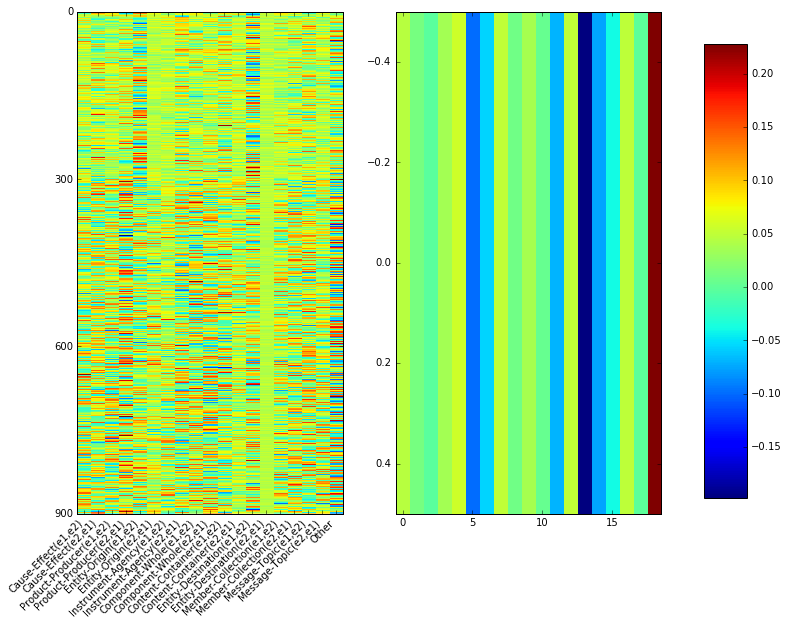

In [94]:
embeds = drnn.score_w.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds[:,:], aspect='auto', interpolation='nearest')

embeds = drnn.score_bias.eval().reshape([1,-1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax0.set_yticks([0,300,600,900])
ax0.set_xticks(range(19))
ax0.set_xticklabels([int2label[c] for c in range(19)], rotation=45, ha='right')
# ax0.grid()

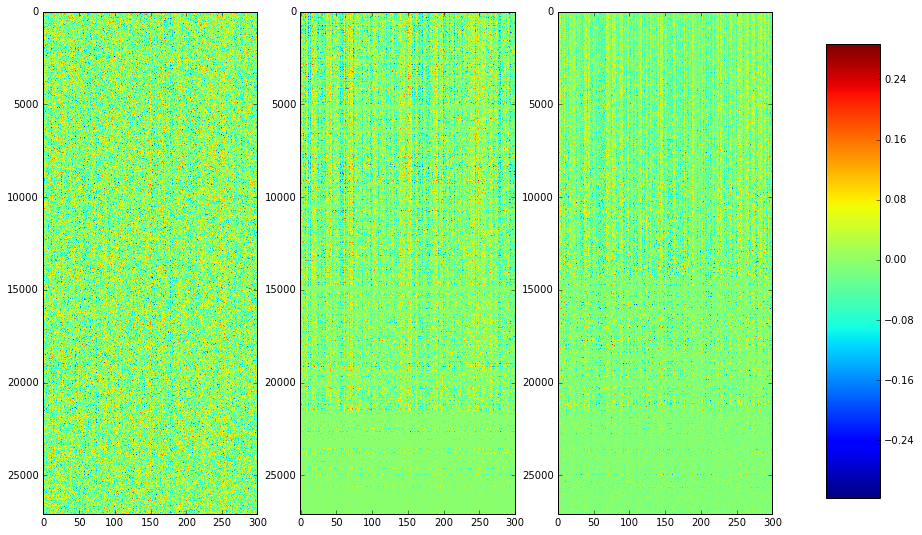

In [31]:
# embeddings
embeds = word_embeddings
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')#, vmin=-2, vmax=2)

embeds = drnn._word_embeddings.eval()
ax1.imshow(embeds, aspect='auto', interpolation='nearest')#, vmin=-2, vmax=2)

embeds = drnn._target_embeddings.eval()
ax2.imshow(embeds, aspect='auto', interpolation='nearest')#, vmin=-2, vmax=2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Top half is input, bottom is r*candidate

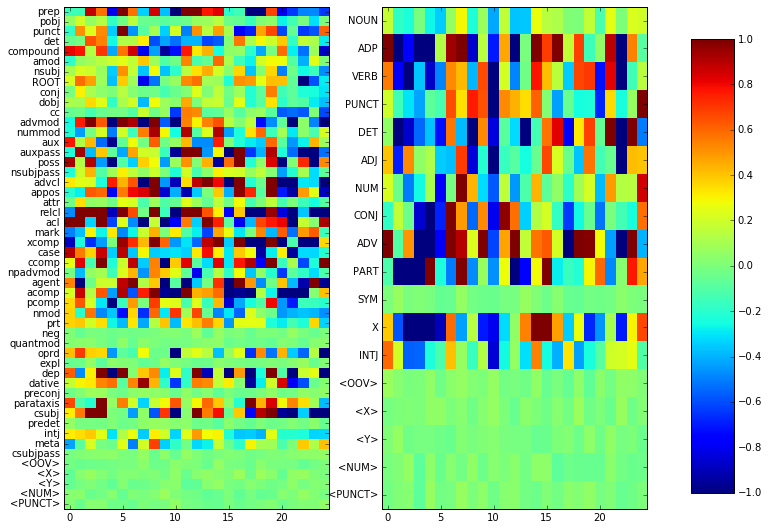

In [33]:
# dep and pos embeddings
embeds = drnn._dependency_embeddings.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest', vmin=-1, vmax=1)
ax0.set_yticklabels(DH._dep_vocab)
ax0.set_yticks(range(len(DH._dep_vocab)))

embeds = drnn._pos_embeddings.eval()
ax1.imshow(embeds, aspect='auto', interpolation='nearest', vmin=-1, vmax=1)
ax1.set_yticklabels(DH._pos_vocab)
ax1.set_yticks(range(len(DH._pos_vocab)))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [40]:
print(tf.get_default_graph().get_operations())

[<tensorflow.python.framework.ops.Operation object at 0x1266a8c50>, <tensorflow.python.framework.ops.Operation object at 0x181f76090>, <tensorflow.python.framework.ops.Operation object at 0x181f76750>, <tensorflow.python.framework.ops.Operation object at 0x181f76290>, <tensorflow.python.framework.ops.Operation object at 0x181f764d0>, <tensorflow.python.framework.ops.Operation object at 0x181f76050>, <tensorflow.python.framework.ops.Operation object at 0x181f7ed10>, <tensorflow.python.framework.ops.Operation object at 0x181f7eb50>, <tensorflow.python.framework.ops.Operation object at 0x181f76a90>, <tensorflow.python.framework.ops.Operation object at 0x181f7ec10>, <tensorflow.python.framework.ops.Operation object at 0x181f7e410>, <tensorflow.python.framework.ops.Operation object at 0x28499f110>, <tensorflow.python.framework.ops.Operation object at 0x28499fd50>, <tensorflow.python.framework.ops.Operation object at 0x28499fdd0>, <tensorflow.python.framework.ops.Operation object at 0x181f7e

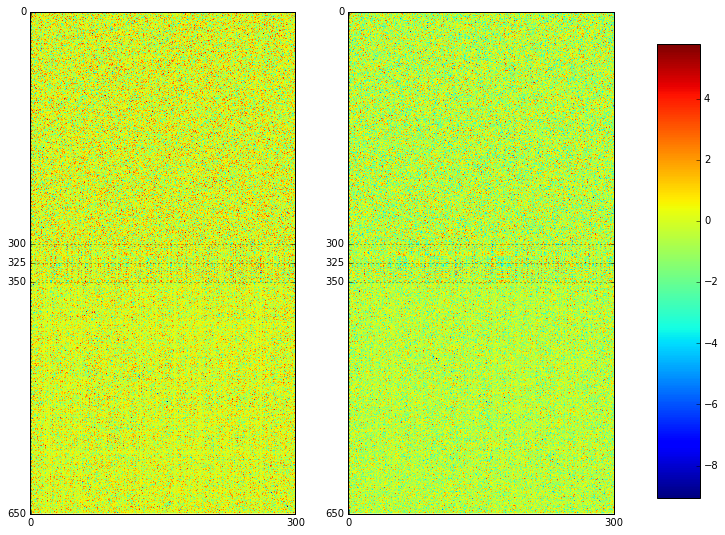

In [30]:
# GRU candidate matrix
with tf.variable_scope('FW', reuse=True):
    embeds = tf.get_variable("GRUCell/Candidate/Linear/Matrix").eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

with tf.variable_scope('BW', reuse=True):
    embeds = tf.get_variable("GRUCell/Candidate/Linear/Matrix").eval()
# embeds = drnn._cand_bias.eval().reshape([1,-1])
ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
ax0.set_yticks([0,300,325,350,650])
ax0.set_xticks([0, 300])
ax0.grid()

ax1.set_yticks([0,300,325,350,650])
ax1.set_xticks([0, 300])
ax1.grid()
### Top half is input, bottom is r*candidate

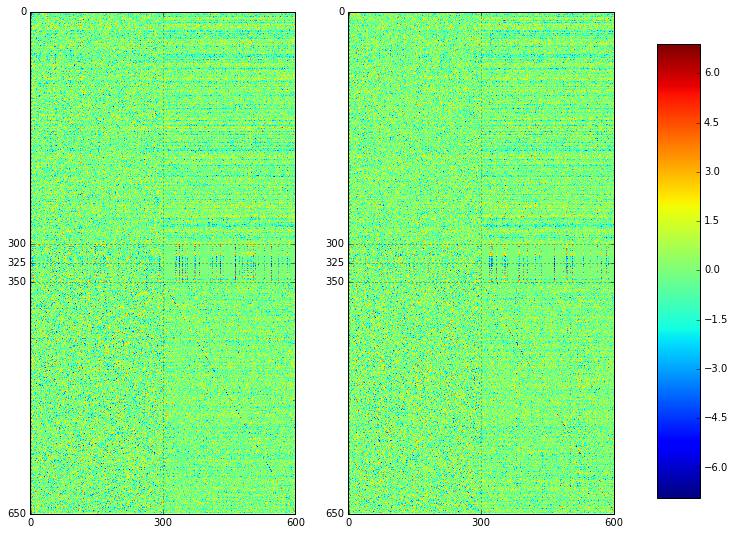

In [28]:
# GRU candidate matrix
with tf.variable_scope('FW', reuse=True):
    embeds = tf.get_variable("GRUCell/Gates/Linear/Matrix").eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

with tf.variable_scope('BW', reuse=True):
    embeds = tf.get_variable("GRUCell/Gates/Linear/Matrix").eval()
# embeds = drnn._cand_bias.eval().reshape([1,-1])
ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax0.set_yticks([0,300,325,350,650])
ax0.set_xticks([0, 300, 600])
ax0.grid()

ax1.set_yticks([0,300,325,350,650])
ax1.set_xticks([0, 300, 600])
ax1.grid()
# Left is r, right is z

In [ ]:
# visualize embedding of large number of phrases
